# High-dimensional MMD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
import pickle

Different combinations of $(X, Y)$ to evaluate the approximation methods.

## Examples of higher-dimensional distributions

`delta` is the departure from $H_0: P_X = P_Y$ of MMD. If it is non-zero, the alternative hypothesis $H_1: P_X \neq P_Y$ is true.

In [2]:
# dimensions
dim = 10   # resulting dimensions is dim+1

# mean or variance shift
delta = 0
 
# how many samples
sample_size = 256
sample_points = np.linspace(0, 1, dim)

# set how far to shift Y (+ shifts to the left, - shifts to the right)
shift_par = 0

print('Shifting for:', shift_par)

Shifting for: 0


# Generating high-dimensional distributions 

## Generating process for mean shift

In [3]:
# generating distributions over time for mean shift

def gen_mean_shift(sample_size, sample_points, delta=0, sd=np.sqrt(0.25), random_state=None):
    """    
    sample_size : number of function samples
    sample_points : observation points
    delta : the coefficient of X^3
    sd : the standard deviation of the observation noise
    """
    rng = np.random.RandomState(random_state)
    n_points = len(sample_points)
    X = rng.normal(0, np.sqrt(10), (sample_size,1)) * np.sqrt(2) * np.sin(2*np.pi*sample_points) + rng.normal(0, np.sqrt(5), (sample_size,1)) * np.sqrt(2) * np.cos(2*np.pi*sample_points)    # Fourier basis functions
    X += sample_points + delta * sample_points**3    # adding mean function
    X += rng.normal(0, sd, (sample_size,n_points))    # adding noise epsilon
    return X

In [4]:
time1d = gen_mean_shift(sample_size, sample_points, delta=0)
time2d = gen_mean_shift(sample_size, sample_points, delta=0)

## Generating process for variance shift

In [ ]:
# generating distributions over time for variance shift

def gen_variance_shift(sample_size, sample_points, delta=0, sd=np.sqrt(0.25), random_state=None):
    """    
    sample_size : number of function samples
    sample_points : observation points
    delta : controls the variance of the sin term.
    sd : the standard deviation of the observation noise
    """
    rng = np.random.RandomState(random_state)
    n_points = len(sample_points)
    X = rng.normal(0, np.sqrt(10+delta), (sample_size,1)) * np.sqrt(2) * np.sin(2*np.pi*sample_points) + rng.normal(0, np.sqrt(5), (sample_size,1)) * np.sqrt(2) * np.cos(2*np.pi*sample_points)
    X += rng.normal(0, sd, (sample_size,n_points))    # adding noise epsilon
    return X

In [ ]:
time1d = gen_mean_shift(sample_size, sample_points, delta=0)
time2d = gen_mean_shift(sample_size, sample_points, delta=0)

### Plottings

(256, 10)


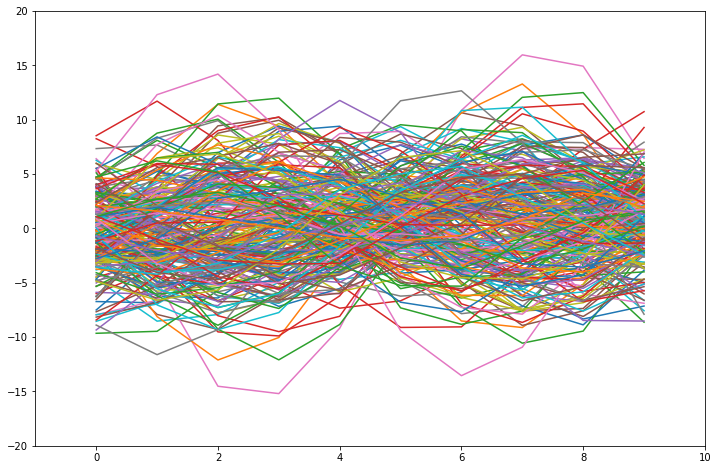

In [5]:
# different dimensions
print(time1d.shape)
plt.figure(figsize=(12,8))
plt.axis([-1, time1d.shape[1], -20, 20])
plt.plot(time1d.T);
plt.show()

(256, 10)


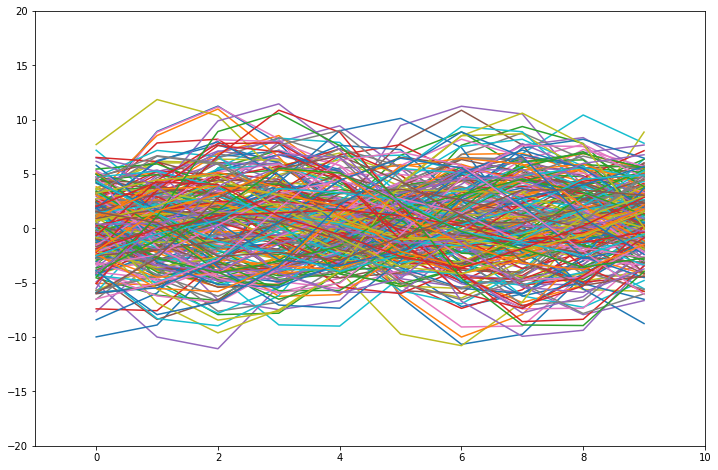

In [6]:
print(time2d.shape)
plt.figure(figsize=(12,8))
plt.axis([-1, time2d.shape[1], -20, 20])
plt.plot(time2d.T);
plt.show()

In [7]:
# same dimensions
if shift_par > 0:
    X = time1d[:, :-shift_par]
    Y = time2d
elif shift_par < 0:
    X = time1d[:, -shift_par:]
    Y = time2d
else:
    X = time1d
    Y = time2d

(256, 10)


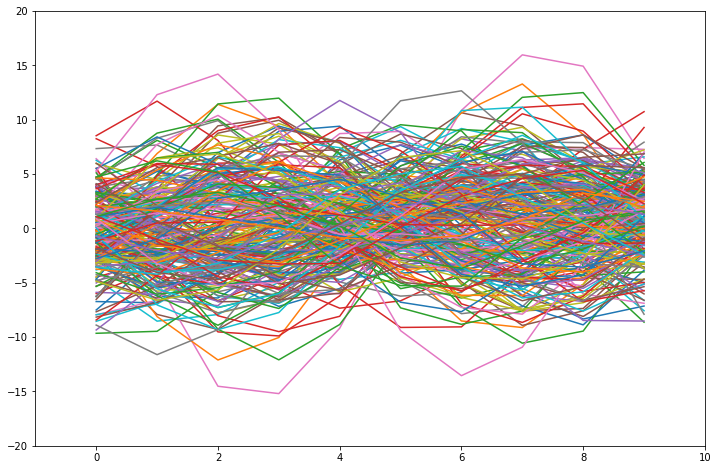

In [8]:
print(X.shape)
plt.figure(figsize=(12,8))
plt.axis([-1, X.shape[1], -20, 20])
plt.plot(X.T);
plt.show()

(256, 10)


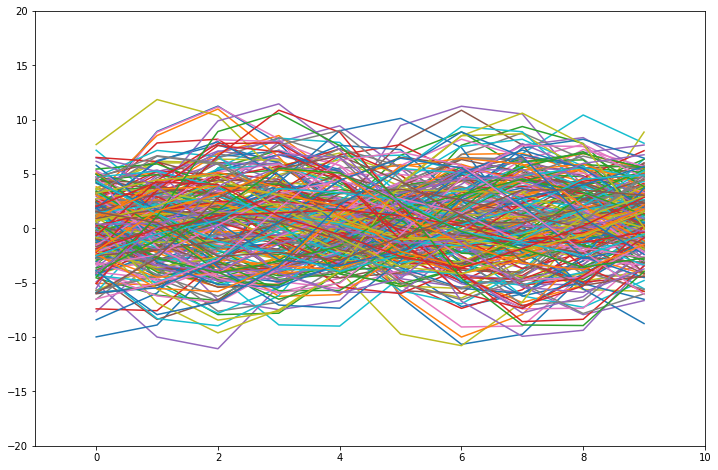

In [9]:
print(Y.shape)
plt.figure(figsize=(12,8))
plt.axis([-1, Y.shape[1], -20, 20])
plt.plot(Y.T);
plt.show()

### Auxiliary functions

In [10]:
# median heuristic for kernel width
def width(Z):
    # compute median for Z
    size_Z = Z.shape[0]
    """
    if size_Z > 100:
        Z_med = Z[0:100]
        size_Z = 100
    else:
    """
    Z_med = Z

    G_Z = np.sum(np.multiply(Z_med, Z_med), axis=1).reshape(-1,1)
    Q_Z = np.tile(G_Z, (1, size_Z))
    R_Z = np.tile(G_Z.T, (size_Z, 1))
    dists_Z = Q_Z + R_Z - 2 * Z_med @ Z_med.T
    distances_Z = (dists_Z - np.tril(dists_Z)).reshape(-1, 1)
    width_Z = np.sqrt(0.5*np.median(distances_Z[distances_Z>0]))
    d_Z = Z.shape[1]
    
    return d_Z * width_Z


# rbf dot product
def rbf_dot(X, Y, width):
    size_X = X.shape
    size_Y = Y.shape
    
    G = np.sum(np.multiply(X, X), axis=1).reshape(-1,1)
    H = np.sum(np.multiply(Y, Y), axis=1).reshape(-1,1)
    
    Q = np.tile(G, (1, size_Y[0]))
    R = np.tile(H.T, (size_X[0], 1))
    
    H = Q + R - 2 * X @ Y.T
    
    # rbf kernel
    K = np.exp(-H/(2*width**2))
    
    return K

---------------------------
### Interlude: can X and Y have different sample sizes?

We test whether our implemented test statistic function `stat_d` produces the same results as the original function `stat` which only works for same sample size of __X__ and **Y**. Both are defined as two multi-variate Gaussians of the same dimension and same sample sizes.

In [ ]:
X_diff = np.random.multivariate_normal([0,1,2], [[1,1,1], [1,1,1], [1,1,1]], size=1024)
Y_diff = np.random.multivariate_normal([10,11,12], [[11,11,11], [11,11,11], [11,11,11]], size=2048)

print(X_diff.shape)
print(Y_diff.shape)

In [ ]:
m = X.shape[0]
n = Y.shape[0]

# compute Gram matrices
K = rbf_dot(X_diff, X_diff, -1)
L = rbf_dot(Y_diff, Y_diff, -1)
KL = rbf_dot(X_diff, Y_diff, -1)

# MMD
stat_d = 1/(m*(m-1)) * np.sum(K) + 1/(n*(n-1)) * np.sum(L) - 1/(m*(m-1)) * np.sum(KL) - 1/(n*(n-1)) * np.sum(KL.T)

In [ ]:
print(stat_d)

------------------------------

# Statistical test based on MMD
We test statistically whether $\mathcal{H}_0 : P_X = P_Y$ holds true.

## MMD with permutations

In [11]:
def MMD_permutations(X, Y, alpha, width_X, width_Y, width_XY, shuffle): # set widths to -1 for median heuristics
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    if width_XY == -1:
        width_XY = width(np.concatenate([X, Y]))
    
    # compute Gram matrices
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    KL = rbf_dot(X, Y, width_XY)
    
    # test statistic
    stat = 1/m * (np.sum(K + L - KL - KL.T))
    
    Kz = np.concatenate((np.concatenate((K, KL), axis=1), np.concatenate((KL.T, L), axis=1)), axis=0)
    
    # initiating MMD
    MMD_arr = np.zeros(shuffle)
    
    # create permutations by reshuffling L except the main diagonal
    for sh in range(shuffle):
        index_perm = np.random.permutation(Kz.shape[0])
        Kz_perm = Kz[np.ix_(index_perm, index_perm)]
        
        K = Kz_perm[:m, :m]
        L = Kz_perm[m:, m:]
        KL = Kz_perm[:m, m:]
        
        MMD_arr[sh] = 1/m * (np.sum(K + L - KL - KL.T))
        
    MMD_arr_sort = np.sort(MMD_arr)
    
    # computing 1-alpha threshold
    threshold = MMD_arr_sort[round((1-alpha)*shuffle)]
        
    """
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    """
    
    return stat, threshold

## MMD with Gamma distribution approximation

In [12]:
def MMD_gamma(X, Y, alpha, width_X, width_Y, width_XY):    # set widths to -1 for median heuristics
    
    m = X.shape[0]
    
    # median heuristics for kernel width
    if width_X == -1:
        width_X = width(X)      
    if width_Y == -1:
        width_Y = width(Y)
    if width_XY == -1:
        width_XY = width(np.concatenate([X, Y]))
    
    # compute Gram matrices
    K = rbf_dot(X, X, width_X)
    L = rbf_dot(Y, Y, width_Y)
    KL = rbf_dot(X, Y, width_XY)
    
    # test statistic
    stat = 1/m * (np.sum(K + L - KL - KL.T))   
    
    # fitting Gamma distribution to stat
    mMMD = 2/m * (1 - 1/m * np.trace(KL))    # mean under H0
    
    K_diag = K - np.diag(np.diag(K))
    L_diag = L - np.diag(np.diag(L))
    KL_diag = KL - np.diag(np.diag(KL))
    
    varMMD = 2/(m*(m-1)) * 1/(m*(m-1)) * np.sum(np.power((K_diag + L_diag - KL_diag - KL_diag.T), 2))    # variance under H0
    
    al = mMMD**2 / varMMD
    bet = varMMD * m / mMMD
    
    # computing 1-alpha threshold
    threshold = gamma.ppf(1-alpha, al, scale=bet)
    
    """
    if stat > threshold:
        print('H0 rejected')
    else:
        print('H0 accepted')
    """
    
    return stat, threshold

### Evaluations

In [13]:
# test level alpha = 0.05, 5000 permutations
MMD_permutations(X, Y, 0.05, -1, -1, -1, 5000)

(0.06492557939642986, 0.08574959266399727)

In [14]:
# test level alpha = 0.05
MMD_gamma(X, Y, 0.05, -1, -1, -1)

(0.06492557939642986, 0.08676143412849548)

## Power estimation

We estimate the statistical power based on 1000 replications for each setting. Our experiment settings compose of various dimensions, sample sizes, mean shifts `delta`, and variance shifts `gam`.

In [15]:
# dimensions
dims = [100]

# sample sizes
sample_sizes = [100, 200, 300, 500]

# mean shift
delta_m = np.linspace(0, 8, 17)

# variance shift
delta_var = np.linspace(0, 8, 17)

# shifting process Y against X
shift_pars = [0] #, 1, 2]

### Power estimation for mean shift

In [16]:
MMD_p_m = {}
MMD_g_m = {}

for dim in dims:
    print('Dimensions:', dim)
    sample_points = np.linspace(0, 1, dim)
    
    for sample_size in sample_sizes:
        print('Sample size:', sample_size)
        for delta in delta_m:
            print('delta:', delta)
            for shift_par in shift_pars:
                #print('Shift:', shift_par)
                
                MMD_p_m_list = []
                MMD_g_m_list = []
                
                # repeating 500 times
                for i in range(500):
                
                    # defining X
                    time1d = gen_mean_shift(sample_size, sample_points, delta=0)    # delta=0 for X

                    # defining Y
                    time2d = gen_mean_shift(sample_size, sample_points, delta=delta)    # delta=delta for Y

                    # bringing X and Y in same space
                    if shift_par > 0:
                        X = time1d[:, :-shift_par]
                        Y = time2d
                    elif shift_par < 0:
                        X = time1d[:, -shift_par:]
                        Y = time2d
                    else:
                        X = time1d
                        Y = time2d

                    # test level alpha = 0.05, 5000 permutations
                    MMD_p_m_list.append(MMD_permutations(X, Y, 0.05, -1, -1, -1, 1000))

                    # test level alpha = 0.05
                    MMD_g_m_list.append(MMD_gamma(X, Y, 0.05, -1, -1, -1))
                    
                MMD_p_m[(dim, sample_size, delta, shift_par)] = MMD_p_m_list
                MMD_g_m[(dim, sample_size, delta, shift_par)] = MMD_g_m_list

Dimensions: 100
Sample size: 100
delta: 0.0
delta: 0.5
delta: 1.0
delta: 1.5
delta: 2.0
delta: 2.5
delta: 3.0
delta: 3.5
delta: 4.0
delta: 4.5
delta: 5.0
delta: 5.5
delta: 6.0
delta: 6.5
delta: 7.0
delta: 7.5
delta: 8.0
Sample size: 200
delta: 0.0
delta: 0.5
delta: 1.0
delta: 1.5
delta: 2.0
delta: 2.5
delta: 3.0
delta: 3.5
delta: 4.0
delta: 4.5
delta: 5.0
delta: 5.5
delta: 6.0
delta: 6.5
delta: 7.0
delta: 7.5
delta: 8.0
Sample size: 300
delta: 0.0
delta: 0.5
delta: 1.0
delta: 1.5
delta: 2.0
delta: 2.5
delta: 3.0
delta: 3.5
delta: 4.0
delta: 4.5
delta: 5.0
delta: 5.5
delta: 6.0
delta: 6.5
delta: 7.0
delta: 7.5
delta: 8.0
Sample size: 500
delta: 0.0
delta: 0.5
delta: 1.0
delta: 1.5
delta: 2.0
delta: 2.5
delta: 3.0
delta: 3.5
delta: 4.0
delta: 4.5
delta: 5.0
delta: 5.5
delta: 6.0
delta: 6.5
delta: 7.0
delta: 7.5
delta: 8.0


In [17]:
# saving
m_shift_p = open('mean_shifts_p_{}.pkl'.format(dims), 'wb')
pickle.dump(MMD_p_m, m_shift_p)
m_shift_p.close()

m_shift_g = open('mean_shifts_g_{}.pkl'.format(dims), 'wb')
pickle.dump(MMD_g_m, m_shift_g)
m_shift_g.close()

### Power estimation for variance shift

In [ ]:
MMD_p_var = {}
MMD_g_var = {}

for dim in dims:
    print('Dimensions:', dim)
    sample_points = np.linspace(0, 1, dim)
    
    for sample_size in sample_sizes:
        print('Sample size:', sample_size)
        for gam in gams:
            print('gamma:', gam)
            for shift_par in shift_pars:
                print('Shift:', shift_par)
                
                MMD_p_var_list = []
                MMD_g_var_list = []
                
                # repeating 200 times
                for i in range(200):
            
                    # defining X
                    time1d = gen_variance_shift(sample_size, sample_points, delta=0)    # delta=0 for X

                    # defining Y
                    time2d = gen_variance_shift(sample_size, sample_points, delta=delta)    # delta=delta for Y

                    # bringing X and Y in same space
                    if shift_par > 0:
                        X = time1d[:, :-shift_par]
                        Y = time2d
                    elif shift_par < 0:
                        X = time1d[:, -shift_par:]
                        Y = time2d
                    else:
                        X = time1d
                        Y = time2d

                    # test level alpha = 0.05, 5000 permutations
                    MMD_p_var_list.append(MMD_permutations(X, Y, 0.05, -1, -1, -1, 5000))

                    # test level alpha = 0.05
                    MMD_g_var_list.append(MMD_gamma(X, Y, 0.05, -1, -1, -1))
                    
                MMD_p_var[(dim, sample_size, delta, shift_par)] = MMD_p_var_list
                MMD_g_var[(dim, sample_size, delta, shift_par)] = MMD_g_var_list

In [ ]:
# saving
var_shift_p = open('var_shifts_p_{}.pkl'.format(dims), 'wb')
pickle.dump(MMD_p_var, var_shift_p)
m_shift_p.close()

var_shift_g = open('var_shifts_g_{}.pkl'.format(dims), 'wb')
pickle.dump(MMD_g_var, var_shift_g)
var_shift_g.close()